In [1]:
from geopy.geocoders import Nominatim 
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |           1_llvm           5 KB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    _pytorch_select-0.2        |            gpu_0           2 KB
    absl-py-0.12.0             |     pyhd8ed1ab_0          96 KB  conda-forge
    aiohttp-3.7.4              |   py37h5e8e339_0         632 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
   

In [2]:
import pandas as pd
import numpy as np
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
address = 'Miami, FL'

geolocator = Nominatim(user_agent="miami_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(miami_venues['Venue Latitude'], miami_venues['Venue Longitude'], miami_venues['Venue'], miami_venues['Venue Category']):
    label = folium.Popup(str(poi) + ', a ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

 
## Start of second iteration   -----------------------------------------------------------------------------------------
 

In [6]:
def createDataFrameGrid(centerlat,centerlon,multiple,radius):

    latmult = 1/121333
    lonmult = 1/96067
    dfgList = []
    Neighborhood = 1
    
    dfgList.append([Neighborhood,centerlat,centerlon])
    Neighborhood = Neighborhood + 1
    
    for i in range(-multiple,multiple + 1):
        for j in range(-multiple,multiple + 1):
            if not (i == 0 and j == 0):
                dfgList.append([Neighborhood, centerlat + i*latmult*radius, centerlon + j*lonmult*radius])
                Neighborhood = Neighborhood + 1
                
    DFG = pd.DataFrame([item for item in dfgList])
    DFG.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude']           
          
    return(DFG)

## 3rd Iteration -------------------------------

Outline:

    1. create grid for API calls
    2. run API calls and get data set 1 with overlapping data
    3. create data set 2 by removing duplicates
    4. create data set 3 as only coffee shops from data set 2 with Venue, Venue Lat, and Venue Lon as the new Neighborhood, Lat, and Lon
    5. run API calls on coffee shops as neighboor hood for data set 4
    6. merge data set 1 and 4 to create data set 5 and run kmeans to see which ds1 neighborhoods are grouped with the coffee shop
    7
    









In [7]:
# create grid to run api calls and run getNearbyVeneus on grid to get 1st data set

dfGrid = createDataFrameGrid(latitude,longitude,10,500)
miami_venues_ds0 = getNearbyVenues(names=dfGrid['Neighborhood'],latitudes=dfGrid['Latitude'],longitudes=dfGrid['Longitude'])



In [8]:
# create function to assign a new category based on the venue category

def createCategory2(venuesDF):

    venuesDF['Category2']=""

    for rowNum in range(len(venuesDF.index)):

        vc1 = venuesDF.iloc[rowNum,6]

        if "Restaurant" in vc1:
            venuesDF.iloc[rowNum,7] = "Restaurant"
        elif vc1 == "Coffee Shop":
            venuesDF.iloc[rowNum,7] = "Coffee Shop"
        elif vc1 in "Sandwich Place,Café,Bakery,Bistro,Salad Place,Gastropub,Burger Joint,Food Truck,Steakhouse,Diner,Beer Garden,Pizza Place,BBQ Joint,Fried Chicken Joint,Taco Place,Burrito Place,Food Stand,Wings Joint,Food Court,Deli / Bodega,Breakfast Spot,Poke Place":
            venuesDF.iloc[rowNum,7] = "Restaurant"        
        elif "Salon" in vc1:
            venuesDF.iloc[rowNum,7] = "Salon"
        elif vc1 in "Light Rail Station,Bus Station,Bus Stop,Train Station,Boat or Ferry,Rental Car Location,Plane,Airport,Cruise Ship,Port,Pier,General Travel":
            venuesDF.iloc[rowNum,7] = "Transportaion" 
        elif vc1 in "Gym,Gym / Fitness Center,Cycle Studio,Pilates Studio,Martial Arts School,General Entertainment,Athletics & Sports,Yoga Studio,Tennis Court,Baseball Field,Basketball Stadium,Baseball Stadium,Zoo,Playground,Track,Beach,Harbor / Marina,Park,Pool,Skate Park,Surf Spot,Trail,Dog Run,Soccer Field,Scenic Lookout":
            venuesDF.iloc[rowNum,7] = "Recreation"
        elif vc1 in "Hotel Pool,Toll Plaza,Residential Building (Apartment / Condo),Event Space,Toll Booth,Island,Tunnel,Intersection,Plaza,Monument / Landmark,Public Art,River,Building,Neighborhood,Outdoor Sculpture,Exhibit,Moving Target":
            venuesDF.iloc[rowNum,7] = "Not Relevent"
        elif vc1 in "Art Gallery,Art Museum,Performing Arts Venue,Music Venue,Indie Movie Theater,Multiplex,Historic Site,Science Museum,Aquarium,Concert Hall,History Museum":
            venuesDF.iloc[rowNum,7] = "Culture"
        elif vc1 in "Nightclub,Speakeasy,Other Nightlife,Lounge":
            venuesDF.iloc[rowNum,7] = "Bar"    
        elif vc1 in "Pharmacy,Fish Market,Flea Market,Farmers Market,Boutique":
            venuesDF.iloc[rowNum,7] = "Shop"
        elif vc1 in "Spa,Health & Beauty Service":
            venuesDF.iloc[rowNum,7] = "Salon"
        elif vc1 in "Lawyer,Construction & Landscaping,Office,Pet Service,Business Service,Home Service,Brewery,Gun Range":
            venuesDF.iloc[rowNum,7] = "Office/Business"    
        elif "Bar" in vc1:
            venuesDF.iloc[rowNum,7] = "Bar"
        elif "Shop" in vc1 or "Store" in vc1:
            venuesDF.iloc[rowNum,7] = "Shop"
        else:
            venuesDF.iloc[rowNum,7] = vc1

    return(venuesDF)

In [9]:
# create new data sets and arrive at ds5 which combines the origional grid data with the coffee shop data

miami_venues_ds1 = createCategory2(miami_venues_ds0) # add Category2 column
miami_venues_ds2 = miami_venues_ds1.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'])
miami_venues_ds3 = miami_venues_ds2.loc[miami_venues_ds2['Category2']=="Coffee Shop"][['Venue','Venue Latitude','Venue Longitude']] # filter for coffee shops

# make coffee shop locations unique by combining name and index
miami_venues_ds3b = miami_venues_ds3.reset_index(drop=True)
miami_venues_ds3c = miami_venues_ds3b.reset_index()
miami_venues_ds3c['index'] = miami_venues_ds3c['index'].apply(str)
miami_venues_ds3c['Venue'] = miami_venues_ds3c['Venue'] + miami_venues_ds3c['index']
miami_venues_ds3 = miami_venues_ds3c[['Venue','Venue Latitude','Venue Longitude']]

# get nearby venues for coffee shop 'neighborhoods'
miami_venues_ds4 = getNearbyVenues(names=miami_venues_ds3['Venue'],latitudes=miami_venues_ds3['Venue Latitude'],longitudes=miami_venues_ds3['Venue Longitude'])
miami_venues_ds4 = createCategory2(miami_venues_ds4) # add Category2 column to coffee shop 'neighborhood' df
miami_venues_ds5 = pd.concat([miami_venues_ds1,miami_venues_ds4]) # combine coffeeshop neighborhood data with grid neighborhood data

In [10]:

# one hot encoding
miami_onehot = pd.get_dummies(miami_venues_ds5.loc[miami_venues_ds5['Category2']!="Not Relevent"][['Category2']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
miami_onehot['Neighborhood'] = miami_venues_ds5.loc[miami_venues_ds5['Category2']!="Not Relevent"]['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [miami_onehot.columns[-1]] + list(miami_onehot.columns[:-1])
miami_onehot = miami_onehot[fixed_columns]

# group onehot data by neighborhood
miami_grouped = miami_onehot.groupby('Neighborhood').mean().reset_index()



In [11]:
# function to sort 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
# create a dataframe with the neighborhoods and a list of the 1st, 2nd, 3rd, etc top Categories

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = miami_grouped['Neighborhood']

for ind in np.arange(miami_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(miami_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Restaurant,Shop,Bar,Coffee Shop,Culture,Salon,Recreation,Office/Business,Outdoor Gym,Outdoors & Recreation
1,2,Recreation,Shop,Restaurant,Supermarket,Airport Food Court,Nightlife Spot,Nutritionist,Office/Business,Outdoor Gym,Outdoors & Recreation
2,3,Restaurant,Shop,Recreation,Bar,Bank,Culture,Salon,Office/Business,Outdoor Gym,Outdoors & Recreation
3,4,Recreation,Shop,Restaurant,Bar,Bank,Coffee Shop,Transportaion,Outdoors & Recreation,Photography Studio,Salon
4,5,Recreation,Restaurant,Coffee Shop,Transportaion,Hot Dog Joint,Shop,Road,Nutritionist,Office/Business,Outdoor Gym


In [13]:
!pip install scikit-learn
from sklearn.cluster import KMeans

In [14]:
# run k means on toronto_grouped_clustering datframe
kclusters = 10
miami_grouped_clustering = miami_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(miami_grouped_clustering)

kmeans.labels_[0:10] 

array([8, 9, 9, 9, 9, 2, 9, 8, 1, 7], dtype=int32)

In [15]:
# add kmeans results to the neighborhoods_venue_sorted dataframe

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [16]:
neighborhoods_venues_sorted.tail(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
415,8,Starbucks6,Restaurant,Shop,Bar,Recreation,Coffee Shop,Bank,Culture,Outdoors & Recreation,Photography Studio,Recording Studio
416,8,Starbucks7,Restaurant,Shop,Bar,Recreation,Coffee Shop,Bank,Culture,Outdoors & Recreation,Photography Studio,Recording Studio
417,8,Suite Habana Cafe33,Restaurant,Culture,Shop,Bar,Coffee Shop,Office/Business,Recreation,Salon,Outdoor Gym,Outdoors & Recreation
418,9,The Grand Coffee of America28,Restaurant,Recreation,Culture,Bar,Shop,Coffee Shop,Transportaion,Bank,Photography Studio,Waterfront
419,9,Vice City Bean25,Bar,Restaurant,Shop,Culture,Recreation,Coffee Shop,Bank,Transportaion,Photography Studio,Salon


In [17]:
# add Neighborhood Type column

neighborhoods_venues_sorted['Neighborhood Type'] = ""

for rowNum in range(len(neighborhoods_venues_sorted.index)):
    if type(neighborhoods_venues_sorted.iloc[rowNum,1]) == int:
        neighborhoods_venues_sorted.iloc[rowNum,12] = 'Grid Neighborhood'
    else:
        neighborhoods_venues_sorted.iloc[rowNum,12] = 'Coffee Shop Neighborhood'

neighborhoods_venues_sorted.tail(50)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Neighborhood Type
370,8,429,Restaurant,Shop,Salon,Office/Business,Dance Studio,Road,Nutritionist,Outdoor Gym,Outdoors & Recreation,Photography Studio,Grid Neighborhood
371,8,430,Restaurant,Culture,Shop,Coffee Shop,Office/Business,Bar,Dance Studio,Outdoor Gym,Outdoors & Recreation,Photography Studio,Grid Neighborhood
372,8,431,Restaurant,Shop,Culture,Bar,Coffee Shop,Arcade,Recreation,Spiritual Center,Resort,Rental Service,Grid Neighborhood
373,8,432,Restaurant,Shop,Recreation,Coffee Shop,Culture,Arcade,Bar,Gas Station,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood
374,2,433,Recreation,Resort,Airport Food Court,Road,Nightlife Spot,Nutritionist,Office/Business,Outdoor Gym,Outdoors & Recreation,Photography Studio,Grid Neighborhood
375,8,441,Coffee Shop,Restaurant,Airport Food Court,Nutritionist,Office/Business,Outdoor Gym,Outdoors & Recreation,Photography Studio,Pool Hall,Recording Studio,Grid Neighborhood
376,0,Angelina's Coffee & Yogurt38,Shop,Restaurant,Coffee Shop,Bar,Culture,Arcade,Recreation,Office/Business,Outdoor Gym,Outdoors & Recreation,Coffee Shop Neighborhood
377,0,Bsweet40,Shop,Restaurant,Culture,Coffee Shop,Bar,Arcade,Recreation,Dance Studio,Salon,Office/Business,Coffee Shop Neighborhood
378,8,Cacique Cuban Restaurant13,Restaurant,Shop,Recreation,Salon,Bar,Culture,Road,Nutritionist,Office/Business,Outdoor Gym,Coffee Shop Neighborhood
379,1,Cafe Al Bacio18,Transportaion,Restaurant,Coffee Shop,Office/Business,Resort,Culture,Road,Nutritionist,Outdoor Gym,Outdoors & Recreation,Coffee Shop Neighborhood


<AxesSubplot:>

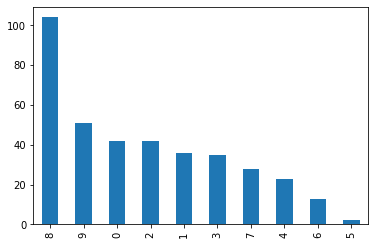

In [18]:
pd.value_counts(neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood Type']== 'Grid Neighborhood']['Cluster Labels']).plot.bar()


<AxesSubplot:>

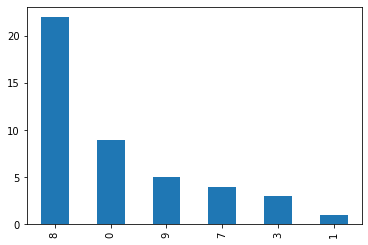

In [19]:
pd.value_counts(neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood Type']== 'Coffee Shop Neighborhood']['Cluster Labels']).plot.bar()

In [20]:
neighborhoods_venues_sorted[['Cluster Labels','Neighborhood','Neighborhood Type']].groupby(['Cluster Labels','Neighborhood Type']).agg(['count'])

Neighborhood
                                               count
Cluster Labels Neighborhood Type                    
0              Coffee Shop Neighborhood            9
               Grid Neighborhood                  42
1              Coffee Shop Neighborhood            1
               Grid Neighborhood                  36
2              Grid Neighborhood                  42
3              Coffee Shop Neighborhood            3
               Grid Neighborhood                  35
4              Grid Neighborhood                  23
5              Grid Neighborhood                   2
6              Grid Neighborhood                  13
7              Coffee Shop Neighborhood            4
               Grid Neighborhood                  28
8              Coffee Shop Neighborhood           22
               Grid Neighborhood                 104
9              Coffee Shop Neighborhood            5
               Grid Neighborhood                  51

In [21]:
# add Latitude and Longitude to neighborhoods_venues_sorted

neighborhoods_venues_sorted['Latitude'] = 1
neighborhoods_venues_sorted['Longitude'] = 1

for rowNum in range(len(neighborhoods_venues_sorted.index)):
    neighborhoods_venues_sorted.iloc[rowNum,13] = miami_venues_ds5.loc[miami_venues_ds5['Neighborhood'] == neighborhoods_venues_sorted.iloc[rowNum,1]].iloc[0,1]
    neighborhoods_venues_sorted.iloc[rowNum,14] = miami_venues_ds5.loc[miami_venues_ds5['Neighborhood'] == neighborhoods_venues_sorted.iloc[rowNum,1]].iloc[0,2]
    
neighborhoods_venues_sorted.head()    

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Neighborhood Type,Latitude,Longitude
0,8,1,Restaurant,Shop,Bar,Coffee Shop,Culture,Salon,Recreation,Office/Business,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood,25.774173,-80.193620
1,9,2,Recreation,Shop,Restaurant,Supermarket,Airport Food Court,Nightlife Spot,Nutritionist,Office/Business,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood,25.732964,-80.245667
2,9,3,Restaurant,Shop,Recreation,Bar,Bank,Culture,Salon,Office/Business,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood,25.732964,-80.240462
3,9,4,Recreation,Shop,Restaurant,Bar,Bank,Coffee Shop,Transportaion,Outdoors & Recreation,Photography Studio,Salon,Grid Neighborhood,25.732964,-80.235258
4,9,5,Recreation,Restaurant,Coffee Shop,Transportaion,Hot Dog Joint,Shop,Road,Nutritionist,Office/Business,Outdoor Gym,Grid Neighborhood,25.732964,-80.230053


In [22]:
### create maping dataset

miami_mapped = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood Type'] == 'Grid Neighborhood']

#miami_mapped = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood Type'] == 'Coffee Shop Neighborhood']


Below is a mapping of the neighborhoods. They are color coded by cluster and the label lists the cluster

In [23]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(miami_mapped['Latitude'], miami_mapped['Longitude'], miami_mapped['Neighborhood'], miami_mapped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_clusters)
       
map_clusters



In [28]:
# create a ranking on neighborhoods in top cluster groups based on number of restarants, shops, and coffee shops

Neighborhoods_venues_sorted_filtered = pd.concat([neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 0],neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 8]])

Neighborhoods_venues_sorted_filtered['CoffeeShopCount'] = 0
Neighborhoods_venues_sorted_filtered['RestaurantCount'] = 0
Neighborhoods_venues_sorted_filtered['ShopCount'] = 0
Neighborhoods_venues_sorted_filtered['RankBy'] = 0

# Assign the number of venues for each Neighborhood to the columns above

for rowNum in range(len(Neighborhoods_venues_sorted_filtered.index)):
    Neighborhoods_venues_sorted_filtered.iloc[rowNum,15] = len(miami_venues_ds1.loc[(miami_venues_ds1['Category2'] == 'Coffee Shop') & (miami_venues_ds1['Neighborhood'] == Neighborhoods_venues_sorted_filtered.iloc[rowNum,1])].index)
    Neighborhoods_venues_sorted_filtered.iloc[rowNum,16] = len(miami_venues_ds1.loc[(miami_venues_ds1['Category2'] == 'Restaurant') & (miami_venues_ds1['Neighborhood'] == Neighborhoods_venues_sorted_filtered.iloc[rowNum,1])].index)
    Neighborhoods_venues_sorted_filtered.iloc[rowNum,17] = len(miami_venues_ds1.loc[(miami_venues_ds1['Category2'] == 'Shop') & (miami_venues_ds1['Neighborhood'] == Neighborhoods_venues_sorted_filtered.iloc[rowNum,1])].index)
    Neighborhoods_venues_sorted_filtered.iloc[rowNum,18] = (Neighborhoods_venues_sorted_filtered.iloc[rowNum,16] + Neighborhoods_venues_sorted_filtered.iloc[rowNum,17])/ (1 + Neighborhoods_venues_sorted_filtered.iloc[rowNum,15])
    
Neighborhoods_venues_sorted_filtered.sort_values(by=['RankBy'], ascending = False).head(5)




,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Neighborhood Type,Latitude,Longitude,CoffeeShopCount,RestaurantCount,ShopCount,RankBy
65,0,86,Shop,Restaurant,Bar,Recreation,Comedy Club,Dance Studio,Airport Food Court,Office/Business,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood,25.749447,-80.245667,0,13,16,29.0
140,8,179,Restaurant,Shop,Recreation,Bar,Bank,Culture,Gas Station,Salon,Photography Studio,Recording Studio,Grid Neighborhood,25.765931,-80.198825,0,19,10,29.0
137,8,176,Restaurant,Shop,Recreation,Bar,Culture,Airport Food Court,Road,Nutritionist,Office/Business,Outdoor Gym,Grid Neighborhood,25.765931,-80.214439,0,18,9,27.0
122,8,158,Restaurant,Recreation,Shop,Bar,Salon,Bank,Nutritionist,Office/Business,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood,25.761810,-80.198825,0,20,5,25.0
108,8,138,Restaurant,Recreation,Bar,Shop,Bank,Salon,Transportaion,Outdoor Gym,Outdoors & Recreation,Road,Grid Neighborhood,25.757689,-80.193620,0,21,2,23.0


In [29]:
miami_mapped_2 = Neighborhoods_venues_sorted_filtered.loc[Neighborhoods_venues_sorted_filtered['RankBy'] > 9]
miami_mapped_2.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Neighborhood Type,Latitude,Longitude,CoffeeShopCount,RestaurantCount,ShopCount,RankBy
65,0,86,Shop,Restaurant,Bar,Recreation,Comedy Club,Dance Studio,Airport Food Court,Office/Business,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood,25.749447,-80.245667,0,13,16,29.0
114,0,150,Shop,Restaurant,Bank,Recreation,Cafeteria,Road,Salon,Nutritionist,Office/Business,Outdoor Gym,Grid Neighborhood,25.761810,-80.240462,0,5,7,12.0
188,0,231,Shop,Restaurant,Transportaion,Hostel,Recreation,Bar,Salon,Tourist Information Center,Massage Studio,Bed & Breakfast,Grid Neighborhood,25.774173,-80.141573,0,6,10,16.0
201,0,244,Shop,Restaurant,Bar,Transportaion,Recreation,Coffee Shop,Culture,Office/Business,Outdoor Gym,Outdoors & Recreation,Grid Neighborhood,25.778294,-80.183211,1,16,17,16.5
274,0,318,Shop,Restaurant,Transportaion,Recreation,Snack Place,Culture,Airport Food Court,Nutritionist,Office/Business,Outdoor Gym,Grid Neighborhood,25.794777,-80.235258,0,5,11,16.0


Mapping the neighborhoods with a RankBy score of greater than 9. There are a few too many results so the RankBy score should be a little higher

In [30]:
miami_mapped_2 = Neighborhoods_venues_sorted_filtered.loc[Neighborhoods_venues_sorted_filtered['RankBy'] > 9]

map_clusters_2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(miami_mapped_2['Latitude'], miami_mapped_2['Longitude'], miami_mapped_2['Neighborhood'], miami_mapped_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_clusters_2)
       
map_clusters_2




Mapping the results with a RankBy score of greater than 10 below. This looks like it provides multiple options without providing too many. The neighborhoods are color coded by the number of coffee shops they contain. The label lists the number of coffee shops, number of restaurants, and the number of shops.

In [31]:
# Map possible locations. Filter the number maped by changeing the RankByLimit variable

RankByLimit = 10

miami_mapped_2 = Neighborhoods_venues_sorted_filtered.loc[Neighborhoods_venues_sorted_filtered['RankBy'] > RankByLimit]
NumCS = Neighborhoods_venues_sorted_filtered.loc[Neighborhoods_venues_sorted_filtered['RankBy'] > RankByLimit]['CoffeeShopCount'].max() + 1

map_clusters_2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(NumCS)
ys = [i + x + (i*x)**2 for i in range(NumCS)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, csc, rest, shp in zip(miami_mapped_2['Latitude'], miami_mapped_2['Longitude'], miami_mapped_2['Neighborhood'], miami_mapped_2['CoffeeShopCount'], miami_mapped_2['RestaurantCount'], miami_mapped_2['ShopCount']):
    label = folium.Popup('Neighborhood: ' + str(poi) + ' CoffeeShopCount: ' + str(csc) + ' RestaurantCount: ' + str(rest) + ' ShopCount: ' + str(shp), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[csc-1],
        fill=True,
        fill_color=rainbow[csc-1],
        fill_opacity=1.0).add_to(map_clusters_2)
       
map_clusters_2